# Import Modules

In [66]:
from os import listdir
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [245]:
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Reading Data

In [31]:
classes_dir = sorted(listdir("data/Kather_texture_2016_image_tiles_5000"))
classes_dir.remove('.DS_Store')
classes_dir

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [37]:
for c in classes_dir:
	files = listdir(f'data/Kather_texture_2016_image_tiles_5000/{c}')
	for f in files:
		print(f'{c}: {f}')

01_TUMOR: 10B61_CRC-Prim-HE-09_022.tif_Row_301_Col_1.tif
01_TUMOR: 4D50_CRC-Prim-HE-04_034.tif_Row_1_Col_601.tif
01_TUMOR: 12A0_CRC-Prim-HE-07_025.tif_Row_451_Col_1.tif
01_TUMOR: 5F7E_CRC-Prim-HE-04_015.tif_Row_1_Col_151.tif
01_TUMOR: 7BA4_CRC-Prim-HE-07_006.tif_Row_1_Col_151.tif
01_TUMOR: 75A6_CRC-Prim-HE-02_005b.tif_Row_1_Col_151.tif
01_TUMOR: 3530_CRC-Prim-HE-08_007.tif_Row_301_Col_301.tif
01_TUMOR: 8E9E_CRC-Prim-HE-03_009.tif_Row_451_Col_301.tif
01_TUMOR: 161D3_CRC-Prim-HE-01_002.tif_Row_1_Col_1.tif
01_TUMOR: 952D_CRC-Prim-HE-02_024.tif_Row_301_Col_301.tif
01_TUMOR: 47AF_CRC-Prim-HE-10_010.tif_Row_1_Col_1.tif
01_TUMOR: 7332_CRC-Prim-HE-01_042.tif_Row_1_Col_601.tif
01_TUMOR: 89F4_CRC-Prim-HE-09_022.tif_Row_1_Col_1.tif
01_TUMOR: 16E99_CRC-Prim-HE-09_010.tif_Row_1_Col_601.tif
01_TUMOR: 16B00_CRC-Prim-HE-05_008.tif_Row_1_Col_451.tif
01_TUMOR: 17EA4_CRC-Prim-HE-05_026.tif_Row_1_Col_151.tif
01_TUMOR: 111E_CRC-Prim-HE-03_028.tif_Row_601_Col_151.tif
01_TUMOR: 15B8C_CRC-Prim-HE-04_032.tif_R

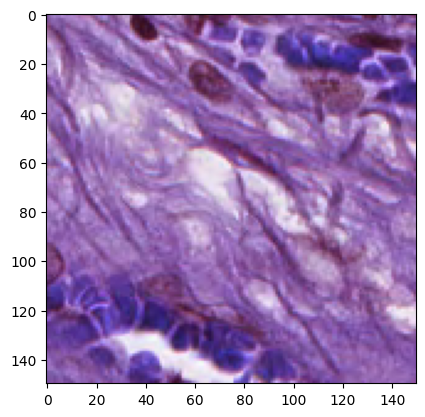

In [41]:
img = cv2.imread('data/Kather_texture_2016_image_tiles_5000/01_TUMOR/89F4_CRC-Prim-HE-09_022.tif_Row_1_Col_1.tif')
plt.imshow(img)

In [58]:
# tf.debugging.set_log_device_placement(True)

when splitting the variable name into '01' and 'tumor', than when doing the hotencoding, the tumor will not be class 0. Because the hotencoding will sort the value alphabetically. Therefore it is easier to pass the variable name as "01_tumor", so will the hot encoding have class 0 as tumor.

In [153]:
with tf.device('/CPU:0'): # running on CPU
	start = datetime.now()
	data = []
	labels_string = []
	path = 'data/Kather_texture_2016_image_tiles_5000'
	for c in classes_dir:
		files = listdir(f'{path}/{c}')
		for f in files:
			# l = c.split('_')[1].lower() # to pass only name of class without numbering.
			labels_string.append(c)
			img = load_img(f'{path}/{c}/{f}', target_size=(128, 128))
			img = img_to_array(img)
			img = preprocess_input(img)
			img = tf.cast(img, tf.float32) / 255.0
			data.append(img)
	end = datetime.now()

	data = np.array(data, dtype='float32')
	labels_string = np.array(labels_string)
	print(end-start)


0:00:01.600132


In [154]:
labels_string

array(['01_TUMOR', '01_TUMOR', '01_TUMOR', ..., '08_EMPTY', '08_EMPTY',
       '08_EMPTY'], dtype='<U10')

In [100]:
data.shape

(5000, 128, 128, 3)

In [155]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_string)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[1 0 0 0 0 0 0 0] 1 <class 'numpy.ndarray'>


Checking for classes

In [202]:
lb.classes_

array(['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS',
       '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'], dtype='<U10')

## Train-split data

In [159]:
# Split into train, val, test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8, random_state=13)
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [197]:
len(y_test)

1000

In [200]:
print(lb.inverse_transform( y_test[0:5] ))
print('--------')
print(y_test)

['03_COMPLEX' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '03_COMPLEX']
--------
[[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [136]:
print(lb.inverse_transform(y_test))

[[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [142]:
print(lb.fit_transform((0, 0, 1, 0, 0, 0, 0, 0)))

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Model

In [246]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of the dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        channel_shift_range=0.,
        # value used for fill_mode = "constant"
        fill_mode='nearest',
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [231]:
EPOCHS = 25

In [205]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(128,128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

In [207]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)      

In [232]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [235]:
history = model.fit(x_train, y_train, batch_size = 32, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/25
125/125 [==============================] - 3s 25ms/step - loss: 0.0139 - accuracy: 0.9963 - val_loss: 1.6599 - val_accuracy: 0.8000
Epoch 2/25
125/125 [==============================] - 3s 24ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 1.5982 - val_accuracy: 0.8120
Epoch 3/25
125/125 [==============================] - 3s 23ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 1.6177 - val_accuracy: 0.8070
Epoch 4/25
125/125 [==============================] - 3s 22ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 1.5380 - val_accuracy: 0.8170
Epoch 5/25
125/125 [==============================] - 3s 23ms/step - loss: 0.0079 - accuracy: 0.9983 - val_loss: 1.4907 - val_accuracy: 0.8200
Epoch 6/25
125/125 [==============================] - 3s 23ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 1.5606 - val_accuracy: 0.8120
Epoch 7/25
125/125 [==============================] - 3s 23ms/step - loss: 0.0080 - accuracy: 0.9983 - val_loss: 1.5613 - val_accuracy: 0.8130

In [248]:
history = model.fit(datagen.flow(x_train, y_train), batch_size = 32, epochs=EPOCHS, validation_data=datagen.flow(x_test, y_test))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8343

2023-03-23 13:04:29.448812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 66ms/step - loss: 0.4467 - accuracy: 0.8343 - val_loss: 0.4024 - val_accuracy: 0.8390
Epoch 2/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3901 - accuracy: 0.8600 - val_loss: 0.4163 - val_accuracy: 0.8440
Epoch 3/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3574 - accuracy: 0.8745 - val_loss: 0.3725 - val_accuracy: 0.8590
Epoch 4/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3592 - accuracy: 0.8715 - val_loss: 0.3772 - val_accuracy: 0.8490
Epoch 5/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3299 - accuracy: 0.8838 - val_loss: 0.4091 - val_accuracy: 0.8590
Epoch 6/25
125/125 [==============================] - 8s 64ms/step - loss: 0.3199 - accuracy: 0.8888 - val_loss: 0.3994 - val_accuracy: 0.8540
Epoch 7/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3125 - accuracy: 0.8898 - val_loss: 0.4065 - val_accuracy: 0.8530
Epoch 8/25

In [229]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 10ms/step - loss: 1.1710 - accuracy: 0.8210


In [249]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

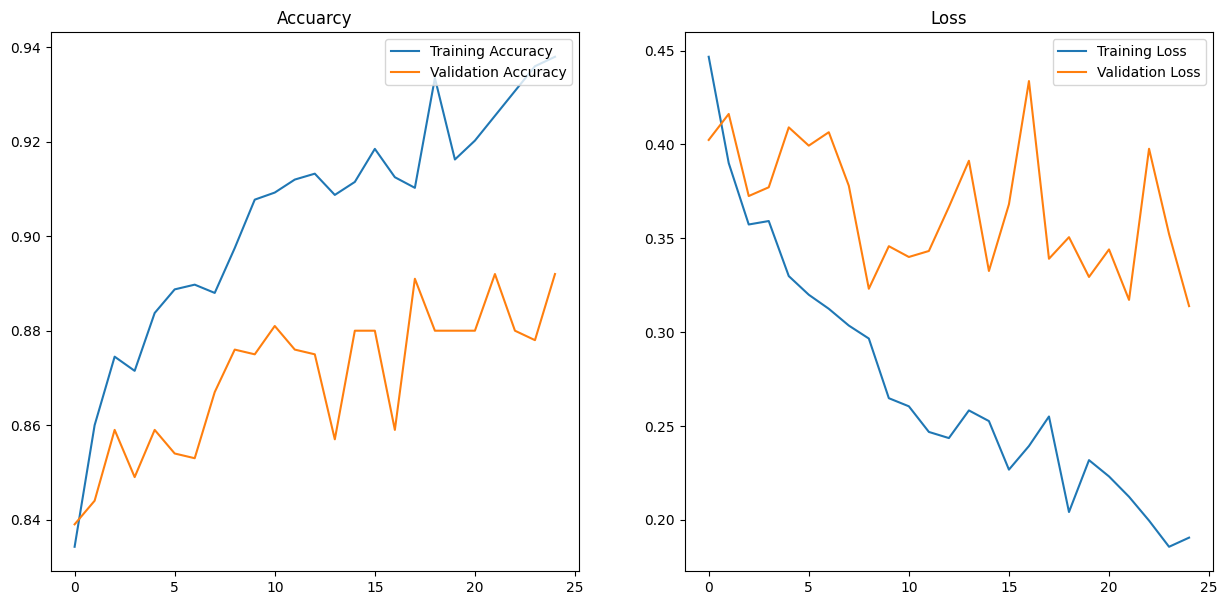

In [250]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title('Accuarcy')
ax1.legend(loc='upper right')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.legend(loc='upper right')
plt.show()